In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, DataStructs, Descriptors, PandasTools

import os
from os.path import join, getsize

from useful_rdkit_utils import mol2numpy_fp

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

from umap import UMAP

import hdbscan

from itertools import product

import concurrent.futures

import seaborn as sns
import matplotlib.pyplot as plt

from chemplot import Plotter

import numba


/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-pac

In [55]:

current_dir = os.path.dirname(os.path.abspath('plots.ipynb'))

# reset the working directory to the notebook's location
print(current_dir)

/home/cree/code/al_data


In [56]:
# create a relative path to the CSV file
oracle_csv_path = os.path.join(current_dir, 'cs_49k.csv')
#oracle_csv_path = 'cs_49k.csv'  # precomputed cnnaffinity as oracle, for 49k mols
oracle_df = pd.read_csv(oracle_csv_path)

In [63]:
def create_test_df(directory):
    """
    Concatenate all selection.csv files from each cycle directory within the specified directory.

    Parameters:
    - directory: str, the path to the directory containing cycle folders.

    Returns:
    - all_selections_df: DataFrame, containing all the data with an additional 'cycle' column.
    """
    # Initialize an empty DataFrame
    all_selections_df = pd.DataFrame()

    # List all cycle directories in the specified directory
    cycle_dirs = [d for d in os.listdir(directory) if
                  os.path.isdir(os.path.join(directory, d)) and d.startswith('cycle_')]

    # Iterate over each directory and append the data to the DataFrame
    for cycle_dir in cycle_dirs:
        cycle_path = os.path.join(directory, cycle_dir, 'selection.csv')
        if os.path.exists(cycle_path):
            # Read the selection.csv file
            cycle_df = pd.read_csv(cycle_path)
            print(cycle_df.columns)
            new_name = 'cnnaffinity'
            if 'combo1' in cycle_df.columns:
                cycle_df.rename(columns={'combo1': new_name}, inplace=True)
            
            if 'plip' in cycle_df.columns:
                cycle_df.rename(columns={'plip': new_name}, inplace=True)
            # Add a 'cycle' column to keep track of the source
            cycle_number = int(cycle_dir.split('_')[1])  # Extract cycle number from the directory name
            cycle_df['cycle'] = cycle_number
            cycle_df['cnnaffinity'] = cycle_df['cnnaffinity'].abs()
            # cycle_df['cnnaffinity'].astype('float').dtypes

            # Append the DataFrame to the main DataFrame
            all_selections_df = pd.concat([all_selections_df, cycle_df], ignore_index=True)
    all_selections_df['expt'] = directory

    print(all_selections_df.columns)
    return all_selections_df


def calculate_performance_metrics(data_df, oracle_df, top_percentage):
    """
    Calculate performance metrics for a given dataframe.

    Parameters:
    - cycle_data: DataFrame for a specific cycle containing 'is_active' column.
    - oracle_df: DataFrame of the oracle data containing 'cnnaffinity' column.
    - threshold: Float, the threshold for determining active compounds.

    Returns:
    - A dictionary containing TP, FP, TN, FN, recall, precision, and F1 score for the cycle.
    """
    # calculate true positives (TP), false positives (FP), and false negatives (FN)
#    test = oracle_df['cnnaffinity'] >= threshold.shape[0] #TODO this has broken, fix
#    print(f'above threshold {test}')
    threshold = oracle_df['cnnaffinity'].quantile(1 - top_percentage)
    TP = data_df['is_active'].sum()  #!! just sum of all the actives, correctly identified as positive via oracle
    FN = oracle_df[oracle_df['cnnaffinity'].astype('float') >= float(threshold)].shape[0] - TP  # all the actives from the oracle, minus the ones we picked i.e. were active but we didnt pick them
    FP = data_df.shape[0] - TP  #!! num mols we picked when we shouldn't
    TN = oracle_df.shape[0] - TP - FP - FN  # only 4 options TP/TN/FP/FN; so total - (TP-FP-FN) = TN

    # ensure the counts add up to the total number of samples
    assert TP + FN + FP + TN == len(oracle_df), "Count mismatch"

    recall = TP / (TP + FN) if TP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0 #check

    print(f"True Positive (TP): {TP}")
    print(f"False Negative (FN): {FN}")
    print(f"False Positive (FP): {FP}")
    print(f"True Negative (TN): {TN}")

    # Check for Count Mismatch
    print(f"Total Samples: {len(oracle_df)}")
    print(f"Sum of Counts (TP+FN+FP+TN): {TP + FN + FP + TN}")

    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")

    return {
        'expt': [data_df['expt'].iloc[0].replace('_generated', '')], #[data_df.cycle.iloc[0]], #
        'TP': [TP],
        'FP': [FP],
        'TN': [TN],
        'FN': [FN],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1_score]
    }


def find_active_mols(df, top_percentage, oracle_df):
    """
    Assign activity to chosen molecules from oracle

    Parameters:
    - df: DataFrame containing 'cnnaffinity'
    - top_percentage: float, the top percentage of 'cnnaffinity' values to consider as 'active'.

    Returns:
    - metrics_df: DataFrame containing 'is_active' column, where active is defined as above top_percentage score in the oracle
    """
    threshold = oracle_df['cnnaffinity'].quantile(1 - top_percentage)
    df['is_active'] = df['cnnaffinity'] >= threshold

    print(f'Threshold for {top_percentage} is {threshold}.')
    print(f'Number of active mols for {df.expt.iloc[0]} is {df.is_active.sum()}.')


    return df

def gather_data(data_dir):
    dir_list = []
    for root, dirs, files in os.walk('.'):
        dir_list.append(dirs) 
    return dir_list[0]


def get_params(exp_list):
    search_strs = [text.split('_') for text in exp_list]
    flat_list = [item for sublist in search_strs for item in sublist]
    param_list = list(set(flat_list))
    return param_list

def gen_rep_data(data_dir, percent=0.02, trunc=True):
    exp_list = gather_data(data_dir)
    df_list = [create_test_df(exp) for exp in exp_list]

    
    if trunc:
        df_sorted = [df.sort_values(by=['cycle'])[:2500] for df in df_list]
    else:
        
        df_sorted = [df.sort_values(by=['cycle']) for df in df_list]
    [len(df) for df in df_sorted]
    df_list = df_sorted
    
    dat = {percent : [find_active_mols(df, float(percent), oracle_df) for df in df_list]}
    
    
    metrics = [calculate_performance_metrics(df, oracle_df, float(percent)) for df in dat[percent]]
    
    metrics = [pd.DataFrame(dict) for dict in metrics]
    metric_df = pd.concat(metrics)
    return df_list, metric_df


def visualize_data(search_string, final_df):
    # Filter DataFrame using Search String
    search_df = final_df[final_df['expt'].str.contains(search_string)]
    
    # Melt the DataFrame for Visualisation
    metrics_melted = pd.melt(search_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='score')
    
    # Plot Data
    fig, ax1 = plt.subplots()
    custom_palette = sns.color_palette("colorblind", n_colors=len(metrics_melted['metric'].unique()))
    g = sns.barplot(x='expt', y='score', hue='metric', data=metrics_melted, ax=ax1, palette=custom_palette, hatch='/')
    
    # Customize Plot
    plt.xticks(rotation=90)
    plt.title(f'{search_string} - Top {percent}')  # Note: 'percent' is not defined in the provided code snippet.
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Cycle size')
    plt.legend(loc=(1.04, 0))

    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.savefig(f'{search_string}_{percent}.png', bbox_inches="tight")
    plt.show()


def create_violin_plot(df_combined):
    """
    Load data from a df and create a violin plot.

    Parameters:
    - directory_path: Path to the directory containing SDF files.
    - plot_title: Title for the violin plot.

    Returns:
    None.
    """
    
    
    df_combined['cycle'] = df_combined['cycle'].astype('int')
    df_combined['cnnaffinity'] = df_combined['cnnaffinity'].astype('float')
    plot_title = df_combined['expt'].iloc[0]

    # Create a violin plot of sf1 vs cycle
    sns.violinplot(x='cycle', y='cnnaffinity', data=df_combined)
    #plt.title(plot_title)
    plt.xlabel('Cycle')
    plt.ylabel('Predicted pK')
    plt.xticks(range(min(df_combined['cycle']), max(df_combined['cycle']) + 1, 2))
    plt.savefig(f'/home/cree/code/gal/cs50k/{plot_title}')
    plt.show()
    return df_combined

def plot_metric_over_cycles(df, metric, oracle_df, percent):
    # Check if the metric is valid
    if metric not in ['recall', 'precision', 'accuracy', 'f1_score']:  # Add other valid metrics if needed
        raise ValueError("Invalid metric specified.")
    expt = df['expt'].iloc[0]
    # Split df into a list of DataFrames based on the 'cycle' column
    max_cycle = df['cycle'].max()
    df_list = [df[df['cycle'] <= i] for i in range(1, max_cycle + 1)]

    # Calculate performance metrics for each DataFrame
    data = [calculate_performance_metrics(df, oracle_df, percent) for df in df_list]

    # Extracting the specified metric values from the data
    metric_values = [entry[metric][0] for entry in data]  # Adjust indexing if necessary

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o')
    plt.title(f'{metric.capitalize()} Values Over Different Cycles')
    plt.xlabel('Cycle')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.xticks(range(1, len(metric_values) + 1))
    
    # Save the plot
    plt.savefig(f'{expt}_{metric}_{percent}.png')
    plt.show()


def visualize_avg_data(search_terms, df_list):
    # Combine all DataFrames in the list
    combined_df = pd.concat(df_list)
    
    # Convert search_terms to a list if it's a single string
    if isinstance(search_terms, str):
        search_terms = [search_terms]
    
    # Apply AND logic in filtering: all terms must be present
    mask = combined_df['expt'].apply(lambda x: all(term in x for term in search_terms))
    search_df = combined_df[mask]
        # Calculate Mean and Standard Deviation
    mean_df = search_df.groupby('expt')[['f1_score', 'recall']].mean().reset_index()
    std_df = search_df.groupby('expt')[['f1_score', 'recall']].sem().reset_index()
    
    # Melt the DataFrames for Visualization
    mean_melted = pd.melt(mean_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='mean_score')
    std_melted = pd.melt(std_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='std_dev')
    
    # Merge Mean and Standard Deviation Data
    merged_df = pd.merge(mean_melted, std_melted, on=['expt', 'metric'])
    print(merged_df)
    # Plot Data
    fig, ax1 = plt.subplots()
    custom_palette = sns.color_palette("colorblind", n_colors=len(merged_df['metric'].unique()))
    g = sns.barplot(x='expt', y='mean_score', hue='metric', data=merged_df, ax=ax1, palette=custom_palette, hatch='/', )
    
    # Add Error Bars
    for i, bar in enumerate(g.patches):
        bar.set_width(0.3)
        hue_index = i % len(merged_df['metric'].unique())
        x = bar.get_x() #+ bar.get_width() #* hue_index
        y = bar.get_height()
        error = merged_df.iloc[i]['std_dev']
        ax1.errorbar(x + bar.get_width()/2, y, yerr=error, fmt='none', color='black', capsize=3)
    
    # Customize Plot
    plt.xticks(rotation=90)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
    plt.title(f'{search_terms[0]} Metrics')
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Experiment')
    plt.legend(loc=(1.04, 0))
    plt.xticks(rotation=90)
    custom_xtick_labels = ['false', 'true',]
    ax1.set_xticklabels(custom_xtick_labels, fontsize=10, rotation=90)
    plt.title(f'{search_terms[0]} Metrics')
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.show()

In [64]:
def smi2svg(smi):
    mol = Chem.MolFromSmiles(smi)
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()
    

def umap(df, nbits=2048):
    """
    Compute UMAP projections for molecular data.

    Parameters:
    - df: Dataframe containing a 'ROMol' column with molecular data.

    Returns:
    - res: UMAP reduced dimensionality output.
    """
    # Compute Morgan Fingerprints
    df['fp'] = df['ROMol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=nbits))
    df['svg'] = df['Smiles'].apply(lambda x: smi2svg(x))
    # Tanimoto Distance function
    def tanimoto_dist(a, b):
        dotprod = np.dot(a, b)
        tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
        return 1.0 - tc

    # UMAP dimensionality reduction
    fps = df['fp'].apply(lambda fp: np.array(fp)).tolist()
    from umap import UMAP
    reducer = UMAP(metric=tanimoto_dist)
    res = reducer.fit_transform(fps)
    
    return res


def cluster_data(df, res, min_samples, min_cluster_size):
    # Apply HDBSCAN clustering on the UMAP results
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, cluster_selection_method='leaf')
    cluster_labels = clusterer.fit_predict(res)

    # Add the cluster labels to the original DataFrame
    df['cluster'] = cluster_labels
    return df

Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid', 'cycle', 'expt'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index([

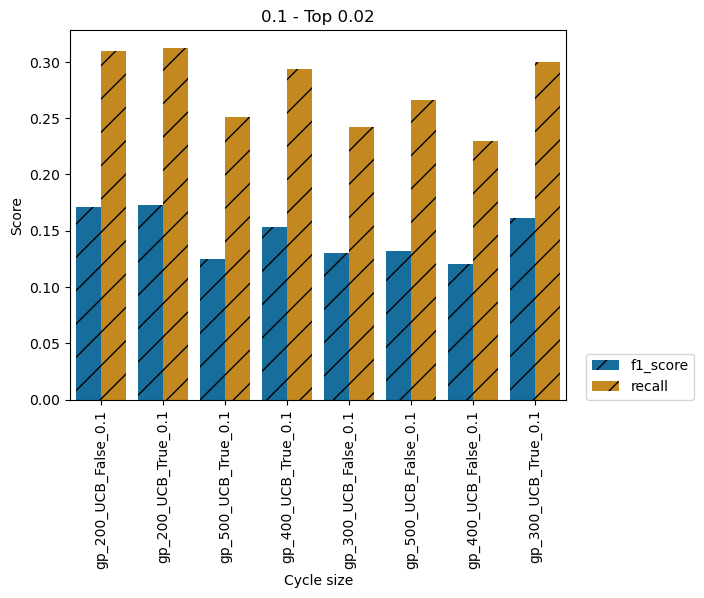

,expt,TP,FP,TN,FN,recall,precision,f1_score
0,gp_200_greedy_False_None,226,2374,46211,766,0.227823,0.086923,0.125835
0,gp_200_UCB_False_0.1,307,2293,46292,685,0.309476,0.118077,0.170935
0,gp_300_UCB_False_10,302,2398,46187,690,0.304435,0.111852,0.163597
0,gp_200_UCB_True_0.1,310,2290,46295,682,0.312500,0.119231,0.172606
0,gp_500_greedy_True_None,269,2731,45854,723,0.271169,0.089667,0.134770
0,gp_200_greedy_True_None,262,2338,46247,730,0.264113,0.100769,0.145880
0,gp_400_UCB_False_1,276,2524,46061,716,0.278226,0.098571,0.145570
0,gp_500_UCB_False_10,294,2706,45879,698,0.296371,0.098000,0.147295
0,gp_300_UCB_False_1,271,2429,46156,721,0.273185,0.100370,0.146804
0,gp_400_UCB_True_1,270,2530,46055,722,0.272177,0.096429,0.142405


In [5]:
data_dir = '/home/cree/code/gal/cs50k/rep_2'
os.chdir(data_dir)

exp_list = gather_data(data_dir)
param_list = get_params(exp_list)
param_list

percent = 0.02
df_list_2, rep2_df = gen_rep_data(data_dir, percent, trunc=False)

visualize_data(param_list[6], rep2_df)
rep2_df

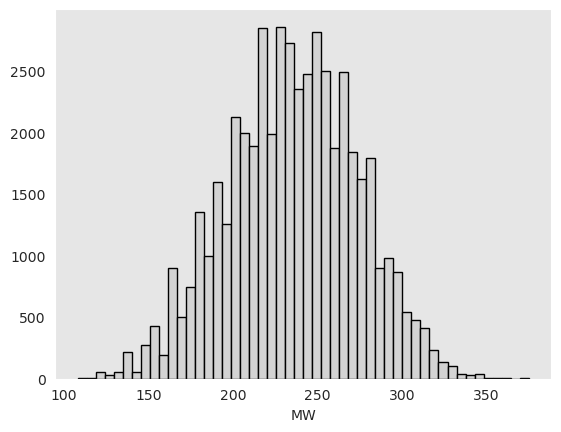

In [14]:
from rdkit.Chem.Descriptors import ExactMolWt

oracle_df['sf1'] = oracle_df['cnnaffinity']
oracle_df['ROMol'] = oracle_df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
oracle_df['MW'] = oracle_df['ROMol'].apply(lambda x: ExactMolWt(x))


# plotting the histogram with adjustments
plt.hist(oracle_df['MW'], color='lightgrey', edgecolor='black', bins=50)

# removing gridlines
plt.grid(False)

# setting x-axis label to 'MW'
plt.xlabel('MW')
plt.savefig('oracle_mw')
# simple histogram of the oracle
plt.show()

In [57]:
oracle_csv_path = os.path.join(current_dir, 'cs_49k.csv')

oracle_df = pd.read_csv(oracle_csv_path)
# Identify duplicates based on 'Smiles' and 'cnnaffinity'
duplicates = oracle_df[oracle_df.duplicated(subset=['Smiles', 'cnnaffinity'], keep=False)]
duplicates

,fid,Smiles,cnnaffinity
2,2,[H]OC(=O)N([H])c1c([H])nc([H])c([H])c1[H],3.68702
6,6,[H]OC([H])([H])Oc1c([H])nc([H])c([H])c1[H],3.15278
11,11,[H]OC([H])([H])N([H])c1c([H])nc([H])c([H])c1[H],3.26906
13,13,[H]OC([H])([H])N([H])C(=O)c1c([H])nc([H])c([H]...,3.57569
14,14,[H]OC(=O)N([H])C([H])([H])c1c([H])nc([H])c([H]...,3.36172
...,...,...,...
49549,50771,[H]c1nc([H])c(C(=O)N([H])S(=O)(=O)c2c([H])c([H...,4.91364
49551,50773,[H]O[C@@]([H])(c1c([H])c([H])c([H])c([H])c1[H]...,3.64487
49559,50782,[H]c1nc([H])c([C@@]([H])(C(=O)N([H])c2c([H])c(...,4.20907
49561,50784,[H]c1nc([H])c(S(=O)(=O)Oc2c([H])c([H])c([H])c(...,4.19305


,cnnaffinity,Smiles,enamine_id,ID,ROMol
0,-6.93227,Fc1cncc(Cl)c1Cc1nc(C2CC23CC3)nn1-c1cccnc1,PV-006887001697,,
1,-6.93157,Fc1cccnc1Cc1nc(C2CC=CCC2)nn1-c1cccnc1,PV-007001170663,,
2,-6.89579,Cc1cccn(Cc2nc(C3CC=CCC3)nn2-c2cccnc2)c1=O,PV-006756558808,,
3,-6.84118,COc1cccnc1Cc1nc(C2CC=CCC2)nn1-c1cccnc1,PV-007167061484,,
4,-6.83884,Cn1ncc(Cl)c1Cc1nc(C2CC=CCC2)nn1-c1cccnc1,PV-006734292620,,
...,...,...,...,...,...
491,-6.00291,CC1CCC(c2nc(CCCN3CCOC3=O)n(-c3cccnc3)n2)CC1,PV-006883739494,,
492,-6.00275,Cc1ccc(OCCc2nc(C3CCOC3)nn2-c2cccnc2)c(C)c1,PV-007142080103,,
493,-6.00105,Cc1cncc(-n2nc(C3CSC3)nc2CCCc2cccnc2)c1,PV-007087461881,,
494,-6.00023,CCCc1nc(Cc2ccccc2Cl)n(-c2cccnc2)n1,PV-006901129565,,

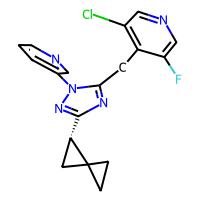
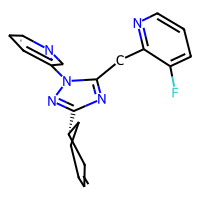
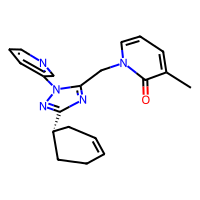
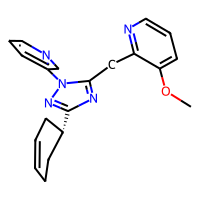
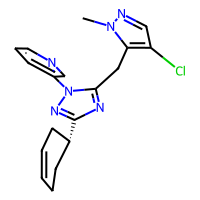
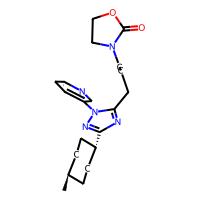
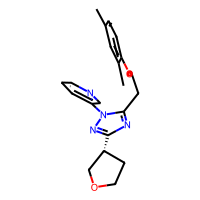
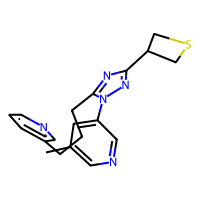
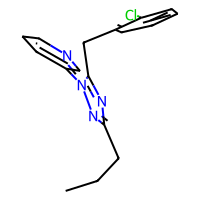
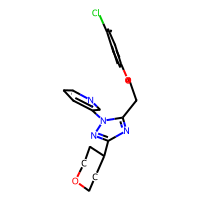

In [58]:
sdf = 'onebyone_it14_over6cnnaffinity.sdf'
enamine_df = PandasTools.LoadSDF(sdf)
enamine_df = enamine_df.rename(columns={'filename': 'Smiles',})
enamine_df 

In [21]:
oracle_df = oracle_df.reset_index(drop=True,)
enamine_df = enamine_df.reset_index(drop=True,)
enamine_oracle_df = pd.concat([oracle_df, enamine_df])
enamine_oracle_df = enamine_oracle_df[['Smiles','cnnaffinity', 'enamine_id']]
enamine_oracle_df.fillna(0,inplace=True)
enamine_oracle_df.cnnaffinity = enamine_oracle_df.cnnaffinity.astype('float').abs()
enamine_oracle_df

,Smiles,cnnaffinity,enamine_id
0,[H]OC([H])([H])c1c([H])nc([H])c([H])c1[H],3.24750,0
1,[H]ON([H])C(=O)c1c([H])nc([H])c([H])c1[H],3.57196,0
2,[H]OC(=O)N([H])c1c([H])nc([H])c([H])c1[H],3.68702,0
3,[H]ON([H])c1c([H])nc([H])c([H])c1[H],3.49225,0
4,[H]OC(=O)c1c([H])nc([H])c([H])c1[H],3.20790,0
...,...,...,...
491,CC1CCC(c2nc(CCCN3CCOC3=O)n(-c3cccnc3)n2)CC1,6.00291,PV-006883739494
492,Cc1ccc(OCCc2nc(C3CCOC3)nn2-c2cccnc2)c(C)c1,6.00275,PV-007142080103
493,Cc1cncc(-n2nc(C3CSC3)nc2CCCc2cccnc2)c1,6.00105,PV-007087461881
494,CCCc1nc(Cc2ccccc2Cl)n(-c2cccnc2)n1,6.00023,PV-006901129565


## Fig 2b

array([[<AxesSubplot:title={'center':'cnnaffinity'}>]], dtype=object)

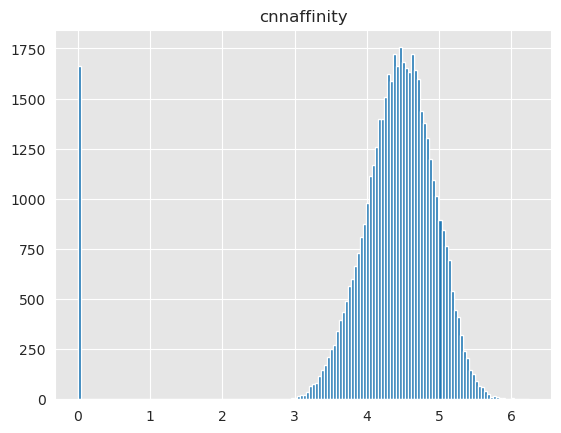

In [23]:
oracle_df.hist('cnnaffinity', bins=150)

## Fig 2c

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

# Custom color map and normalization
my_colors = ['#c7c7c7', 'gold', 'orange', 'red', 'darkred']
my_cmap = ListedColormap(my_colors)
bounds = [3, 4.5, 5, 5.5, 6]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

def plot_umap(df, title, size=100):
    sns.set_style('white')
    plt.figure(figsize=(10, 8))

    # Use custom colormap and norm
    points = plt.scatter(x=df['UMAP-1'], y=df['UMAP-2'], c=df['cnnaffinity'], cmap=my_cmap, norm=my_norm, s=size)
    
    # Creating color bar and legend
    cbar = plt.colorbar(points, spacing='proportional', ticks=bounds, shrink=0.6, aspect=30)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Predicted pK', fontsize=16) 
    #plt.title(f'Chemical space UMAP - {title}', fontsize=16)
    plt.xlabel('UMAP-1', fontsize=16)
    plt.ylabel('UMAP-2', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    
    #plt.legend(title='CNNaffinity', title_fontsize=14, fontsize=14, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(title, bbox_inches='tight')
    plt.show()

In [ ]:
# calculate umap for oracle df
cp = Plotter.from_smiles(enamine_oracle_df["Smiles"],)
res = cp.umap()

In [26]:

oracle_df = oracle_df.reset_index(drop=True,)
res = res.reset_index(drop=True,)
df = pd.concat([oracle_df, res], axis=1)
df['cnnaffinity'] = df['cnnaffinity'].astype(float)
umap_df = df[df['cnnaffinity'] > 0]

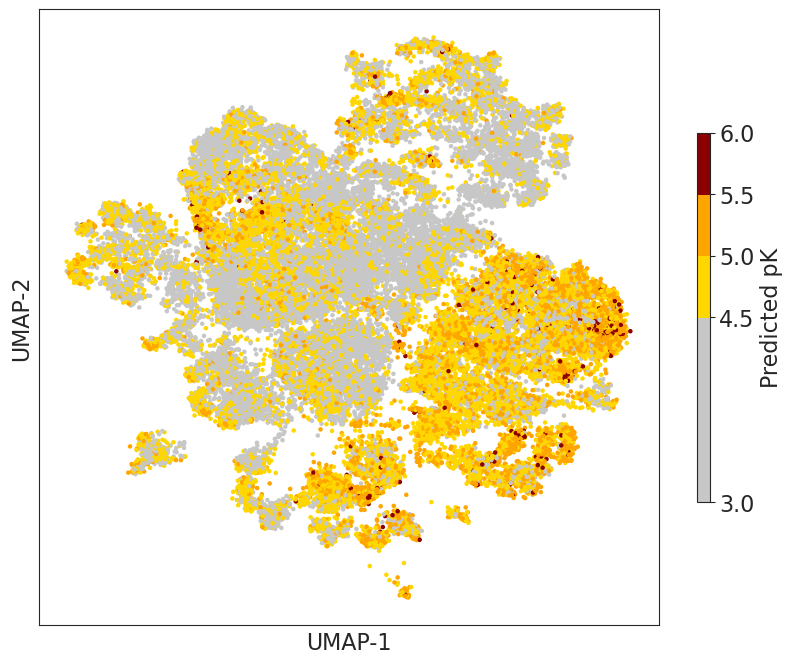

In [27]:
plot_umap(umap_df, '50K', size=5)

In [ ]:
# # assuming create_test_df is a predefined function
# # def create_test_df(path, column): ...

# dfs = [] # list to store each DataFrame

# # generate and store dfs
# for i in range(1, 6):
#     path = f'./rep_{i}/gp_200_UCB_True_10'
#     df = create_test_df(path, 'cnnaffinity')
#     # optionally, add source identifier before appending
#     df['source'] = f'rep_{i}'
#     dfs.append(df)

# # concatenate all dfs
# concatenated_df = pd.concat(dfs, ignore_index=True)
# concatenated_df

## Fig 3 

In [7]:
base_dir = os.path.dirname(os.path.abspath('plots.ipynb'))
df_list = []
# create 5 dfs in a loop with different directories for each rep
dfs = {}
for i in [1,2,3,4,5]:
    data_dir = f'{base_dir}rep_{i}'  # change directory for each rep
    os.chdir(data_dir)
    print(data_dir)
    df_name = f'rep{i}_df'  # naming each df as rep1_df, rep2_df, etc.
    expt_df, dfs[df_name] = gen_rep_data(data_dir, percent, trunc=False)
    df_list.append(expt_df)
# Access dataframes: dfs['rep1_df'], dfs['rep2_df'], ..., dfs['rep5_df']
dfs['rep3_df']

/home/cree/code/al_data/rep_1
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid', 'cycle', 'expt'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', '

,expt,TP,FP,TN,FN,recall,precision,f1_score
0,gp_200_greedy_False_None,226,2374,46211,766,0.227823,0.086923,0.125835
0,gp_200_UCB_False_0.1,307,2293,46292,685,0.309476,0.118077,0.170935
0,gp_300_UCB_False_10,302,2398,46187,690,0.304435,0.111852,0.163597
0,gp_200_UCB_True_0.1,310,2290,46295,682,0.312500,0.119231,0.172606
0,gp_500_greedy_True_None,269,2731,45854,723,0.271169,0.089667,0.134770
0,gp_200_greedy_True_None,262,2338,46247,730,0.264113,0.100769,0.145880
0,gp_400_UCB_False_1,276,2524,46061,716,0.278226,0.098571,0.145570
0,gp_500_UCB_False_10,294,2706,45879,698,0.296371,0.098000,0.147295
0,gp_300_UCB_False_1,271,2429,46156,721,0.273185,0.100370,0.146804
0,gp_400_UCB_True_1,270,2530,46055,722,0.272177,0.096429,0.142405


In [ ]:
#all plots for each individual run, rep1_df for 1, rep2_df for 2 etc
for i in param_list:
    visualize_data(i, dfs['rep1_df'])

In [10]:
# list of parameters which can be used as keys for different f1/recall plots
param_list

['greedy',
 'True',
 '10',
 '1',
 'False',
 'UCB',
 '0.1',
 '500',
 'None',
 '400',
 '200',
 'gp',
 '300']

                    expt    metric  mean_score   std_dev
0   gp_200_UCB_False_0.1  f1_score    0.155568  0.008123
1    gp_200_UCB_True_0.1  f1_score    0.165924  0.010033
2   gp_300_UCB_False_0.1  f1_score    0.130011  0.004464
3    gp_300_UCB_True_0.1  f1_score    0.151029  0.009433
4   gp_400_UCB_False_0.1  f1_score    0.124895  0.012494
5    gp_400_UCB_True_0.1  f1_score    0.147574  0.006501
6   gp_500_UCB_False_0.1  f1_score    0.138677  0.007444
7    gp_500_UCB_True_0.1  f1_score    0.123347  0.004958
8   gp_200_UCB_False_0.1    recall    0.281653  0.014707
9    gp_200_UCB_True_0.1    recall    0.300403  0.018165
10  gp_300_UCB_False_0.1    recall    0.241935  0.008307
11   gp_300_UCB_True_0.1    recall    0.281048  0.017554
12  gp_400_UCB_False_0.1    recall    0.238710  0.023879
13   gp_400_UCB_True_0.1    recall    0.282056  0.012426
14  gp_500_UCB_False_0.1    recall    0.279032  0.014977
15   gp_500_UCB_True_0.1    recall    0.248185  0.009976


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (2).

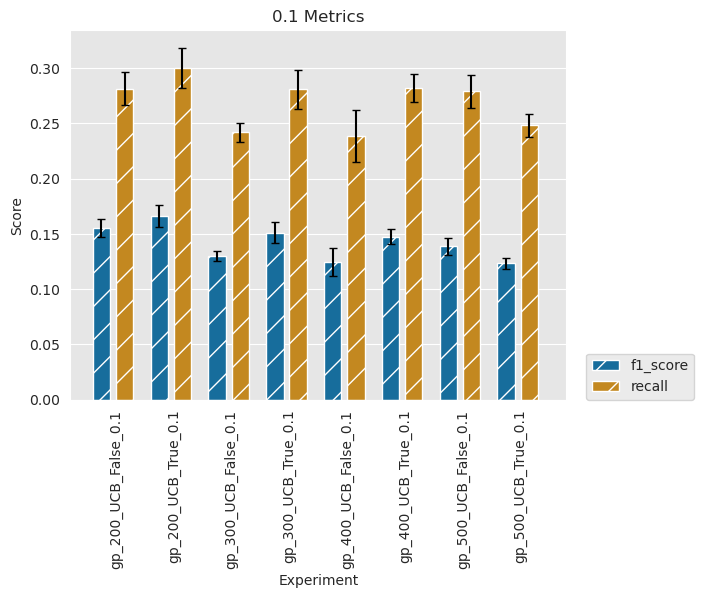

In [11]:
# average f1/recall values over 5 independent runs
# dfs is a dictionary of all reps, accessed via their keys, repX_df
# ignore error
visualize_avg_data(["0.1", "gp",], [dfs[key] for key in ['rep1_df', 'rep2_df', 'rep3_df', 'rep4_df', 'rep5_df']])

## Fig 5

In [59]:
def extract_cycles(df):
    cyc_last = df['cycle'].max()
    first_df = df[df['cycle'] == 1]
    last_df = df[df['cycle'] == cyc_last]
    return {'first' : first_df, 'last' : last_df}
    
# def create_test_df(directory, feature_column):
#     """
#     Concatenate all selection.csv files from each cycle directory within the specified directory.

#     Parameters:
#     - directory: str, the path to the directory containing cycle folders.

#     Returns:
#     - all_selections_df: DataFrame, containing all the data with an additional 'cycle' column.
#     """
#     # Initialize an empty DataFrame
#     all_selections_df = pd.DataFrame()

#     # List all cycle directories in the specified directory
#     cycle_dirs = [d for d in os.listdir(directory) if
#                   os.path.isdir(os.path.join(directory, d)) and d.startswith('cycle_')]

#     # Iterate over each directory and append the data to the DataFrame
#     for cycle_dir in cycle_dirs:
#         cycle_path = os.path.join(directory, cycle_dir, 'selection.csv')
#         if os.path.exists(cycle_path):
#             # Read the selection.csv file
#             cycle_df = pd.read_csv(cycle_path)

#             # Add a 'cycle' column to keep track of the source
#             cycle_number = int(cycle_dir.split('_')[1])  # Extract cycle number from the directory name
#             cycle_df['cycle'] = cycle_number
#             cycle_df[feature_column] = cycle_df[feature_column].abs()
#             # cycle_df['cnnaffinity'].astype('float').dtypes

#             # Append the DataFrame to the main DataFrame
#             all_selections_df = pd.concat([all_selections_df, cycle_df], ignore_index=True)
#     all_selections_df['expt'] = directory
#     return all_selections_df

import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools
import itertools

# function to load and preprocess data
def load_and_preprocess(directory, file_type):
    # load dataframe from a given directory and file type, sort by specified columns
    df = create_test_df(directory, file_type)
    print(df)
    return df.sort_values(['cycle', file_type])

# function to get the last 100 rows for each cycle
def filter_last_100_rows(df):
    unique_cycles = df['cycle'].unique()
    unique_cycles.sort()
    return [df[df['cycle'] == cycle].tail(100) for cycle in unique_cycles]

# function to clean data by dropping NaN values and sorting
def clean_data(df):
    df_cleaned = df.dropna(subset=['enamine_id'])
    return df_cleaned.sort_values(by=['cycle'])

# function to calculate average similarity between two lists of SMILES
def avg_sim(smiles_list1, smiles_list2, radius=5, n_bits=2048):
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius, nBits=n_bits) for smiles in smiles_list1]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius, nBits=n_bits) for smiles in smiles_list2]
    smiles_and_similarities = [(smiles1, smiles2, DataStructs.TanimotoSimilarity(fp1, fp2)) for (smiles1, fp1), (smiles2, fp2) in itertools.product(zip(smiles_list1, fps1), zip(smiles_list2, fps2))]
    return sorted(smiles_and_similarities[:5], key=lambda x: x[2], reverse=True)

# load and preprocess data
# to create umaps for other experiments replace plip with sars-cov-2-mean-protease-al-X/generated
plip_df = load_and_preprocess(f'{base_dir}/sars-cov-2-main-protease-al-study-plip/generated', 'plip')

# filter for last 100 rows of each cycle
cycles_data = filter_last_100_rows(plip_df)

# group, sort, and clean data for NaN handling
grouped = plip_df.groupby('cycle').apply(lambda x: x.sort_values(by='cycle', ascending=False).tail(100)).reset_index(drop=True)
nan_counts_per_cycle = grouped.groupby('cycle')['enamine_id'].apply(lambda x: x.isna().sum())
df_cleaned = clean_data(grouped)

# identify and process new enamine IDs
first_occurrence_mask = df_cleaned.duplicated(subset=['enamine_id'], keep='first')
new_enamine_ids = df_cleaned[~first_occurrence_mask]
unique_enamine_df = new_enamine_ids.sort_values(['cycle'])
unique_enamine_df['enamine_searched'] = True
grouped_unique_enamine_df = unique_enamine_df.groupby('cycle').apply(lambda x: x.sort_values(by='cycle', ascending=False))
enamine_searched_map = grouped_unique_enamine_df.set_index('enamine_id')['enamine_searched']
grouped['enamine_searched'] = grouped['enamine_id'].map(enamine_searched_map).fillna(False)

# def top_n_by_cycle(grouped, n):
#     # calculate chemical similarity
cycle_sim = []
for i in range(1, grouped.cycle.max()):
    query_rows = grouped[(grouped['cycle'] == i)]
    enamine_rows = grouped[(grouped['cycle'] == i+1) & (grouped['enamine_searched'] == True)]
    query_smiles = query_rows['Smiles'].tolist()
    enamine_smiles = enamine_rows['Smiles'].tolist()
    cycle_sim.append(avg_sim(query_smiles, enamine_smiles))

n = 3
PandasTools.RenderImagesInAllDataFrames(images=True)
dfs = []
for i, l in enumerate(cycle_sim):
    df = pd.DataFrame(cycle_sim[i][:n], columns=['query_smi', 'enamine_smi', 'similarity'])
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol='query_smi', molCol='Molecule_query')
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol='enamine_smi', molCol='Molecule_enamine')
    #grab enamine_id for all df.enamine_smi from grouped['Smiles']
    smiles_to_enamine_id_map = dict(zip(grouped['Smiles'], grouped['enamine_id']))
    df['enamine_id'] = df['enamine_smi'].map(smiles_to_enamine_id_map)
    dfs.append(df)

# assuming create_test_df is a predefined function
# def create_test_df(path, column): ...

dfs = [] # list to store each DataFrame

# generate and store dfs
for i in range(1, 6):
    path = f'/home/cree/code/al_data/rep_{i}/gp_200_UCB_True_10'
    df = create_test_df(path, 'cnnaffinity')
    # optionally, add source identifier before appending
    df['source'] = f'rep_{i}'
    dfs.append(df)

# concatenate all dfs
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df

          plip                                             Smiles  h  \
0     0.137931  N#Cc1c(c(c(c(Oc2c(c(nc(N(C(C(C3(C(C(OC3([H])[H...  6   
1     0.068966  [H]c1nc([H])c(-c2c([H])nc([H])c([H])c2[H])nc1C...  6   
2     0.137931  C(OC(C(C(C(N(C(=O)C1(C([H])([H])[H])C(C(c2c(c(...  6   
3     0.000000  [H]c1nc([H])c(N(C([H])([H])[H])S(=O)(=O)S(=O)(...  6   
4     0.071429  O=C(C(c1c(c2c(c(c(c(c2o1)[H])[H])[H])[H])[H])(...  6   
...        ...                                                ... ..   
8995  0.107143  O=C(N(N(C(=S)N(C1(C(C([N+](C(C1([H])[H])([H])[...  6   
8996  0.107143  C(C(c1c(c(c(C(C([N+](C(C(O[H])([H])[H])([H])[H...  6   
8997  0.133333  c1(c(nc(c(C(N(c2c(c(nc3c(c(c(nc23)[H])[H])[H])...  6   
8998  0.103448  C(c1noc(C(C([H])([H])[H])(C([H])([H])[H])[H])c...  6   
8999  0.107143  C(c1noc(C(C([H])([H])[H])(C([H])([H])[H])[H])c...  6   

       enamine_id  enamine_searched  cycle  \
0     Z5023298032             False     31   
1             NaN             False     31 

,cnnaffinity,Smiles,h,fid,cycle,expt,source
0,5.51648,[H]c1nc([H])c(N2C([H])([H])C([H])([H])N(c3c([H...,6,48833,13,/home/cree/code/al_data/rep_1/gp_200_UCB_True_10,rep_1
1,5.23706,[H]c1nc([H])c(-c2nc([H])c(-c3nc([H])c([H])c([H...,6,24357,13,/home/cree/code/al_data/rep_1/gp_200_UCB_True_10,rep_1
2,4.35020,[H]c1nc([H])c(N([H])C(=O)N([H])c2nnc(C([H])([H...,6,47018,13,/home/cree/code/al_data/rep_1/gp_200_UCB_True_10,rep_1
3,4.88979,[H]c1nc([H])c(-c2nc(C([H])([H])c3sc([H])c([H])...,6,23580,13,/home/cree/code/al_data/rep_1/gp_200_UCB_True_10,rep_1
4,4.88703,[H]c1nc([H])c(-c2c([H])nc(C(=O)c3oc([H])c([H])...,6,42758,13,/home/cree/code/al_data/rep_1/gp_200_UCB_True_10,rep_1
...,...,...,...,...,...,...,...
12995,4.96694,[H]c1nc([H])c(-n2nc([H])c(C3([H])C([H])([H])C(...,6,13060,2,/home/cree/code/al_data/rep_5/gp_200_UCB_True_10,rep_5
12996,5.07099,[H]c1nc([H])c(-n2nc([H])c(N([H])c3c([H])c([H])...,6,4360,2,/home/cree/code/al_data/rep_5/gp_200_UCB_True_10,rep_5
12997,4.94944,[H]c1nc([H])c(-n2nc([H])c(-n3c(C([H])([H])[H])...,6,24760,2,/home/cree/code/al_data/rep_5/gp_200_UCB_True_10,rep_5
12998,4.18665,[H]Oc1c([H])nn(-c2c([H])nc([H])c([H])c2[H])c1[H],6,60,2,/home/cree/code/al_data/rep_5/gp_200_UCB_True_10,rep_5


mean cnnaffinity: 4.25843219, # of 0s: 48
           fid                                             Smiles  \
39        39.0             [H]OC([H])=Nc1c([H])nc([H])c([H])c1[H]   
168      168.0  [H]c1nc([H])c(S(=O)(=O)N(OC([H])([H])[H])C([H]...   
169      169.0  [H]c1nc([H])c(N(C([H])([H])[H])S(=O)(=O)OC([H]...   
210      210.0  [H]c1nc([H])c(N([H])S(=O)(=O)N([H])[H])c([H])c...   
270      270.0  [H]c1nc([H])c(S(=O)(=O)N([H])C(=O)N([H])[H])c(...   
...        ...                                                ...   
49348  49885.0  [H]OC(=O)C(O[H])=C([H])C(=O)S(=O)(=O)Oc1c([H])...   
49353  49890.0  [H]OC(=O)C(O[H])=C([H])C(=O)c1nc([H])c([H])c(-...   
49387  49924.0  [H]c1nc([H])c(C#Cc2c([H])nc([H])c(F)c2[H])c([H...   
49497  50719.0  [H]c1nc([H])c(C(=O)C([H])([H])c2c([H])c([H])c(...   
49552  50774.0  [H]c1nc([H])c(-c2nnc(-c3c([H])c([H])c([H])c([H...   

       cnnaffinity    UMAP-1     UMAP-2  
39         3.47747 -3.839685   7.310242  
168        3.58674 -6.353554  10.405433  
169

/tmp/ipykernel_68555/2865019050.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cnnaffinity'] = filtered_df['cnnaffinity'].astype(float)


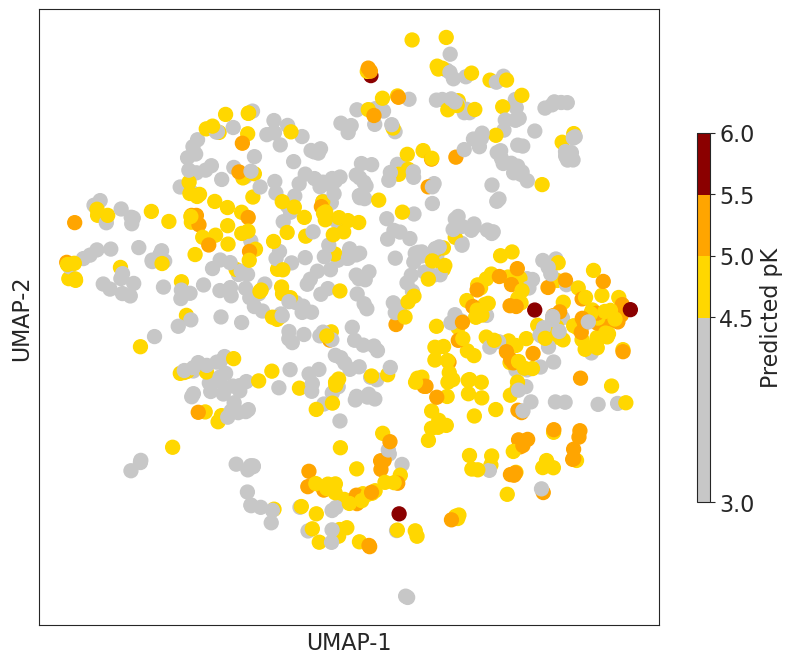

mean cnnaffinity: 4.862944150000001, # of 0s: 25
           fid                                             Smiles  \
1149    1167.0  [H]c1nc([H])c(N([H])C(=S)C([H])([H])c2c([H])c(...   
1178    1196.0  [H]c1nc([H])c(-c2nc([H])n(C([H])([H])c3c([H])c...   
1277    1295.0  [H]c1nc([H])c(-c2nc([H])n(-c3c([H])nc([H])c([H...   
1278    1296.0  [H]c1nc([H])c(-c2nc([H])n(-c3c([H])nc([H])c([H...   
1346    1364.0  [H]c1nc([H])c(-n2nnc(-c3c([H])c([H])nc([H])c3[...   
...        ...                                                ...   
49372  49909.0  [H]c1nc([H])c(S(=O)(=O)N([H])c2c([H])nc([H])c(...   
49379  49916.0  [H]c1nc([H])c(N([H])C(=O)C([H])([H])c2c([H])nc...   
49398  49935.0  [H]c1nc([H])c(N2C([H])([H])C([H])([H])C([H])(c...   
49423  49960.0  [H]c1nc([H])c(-n2nc([H])c(-c3c([H])nc([H])c(F)...   
49438  49975.0  [H]c1nc([H])c(-c2nc([H])c([H])c(-c3c([H])nc([H...   

       cnnaffinity    UMAP-1     UMAP-2  
1149       4.66497 -0.963659  13.175964  
1178       4.90063  3.463558   6.18092

/tmp/ipykernel_68555/2865019050.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cnnaffinity'] = filtered_df['cnnaffinity'].astype(float)


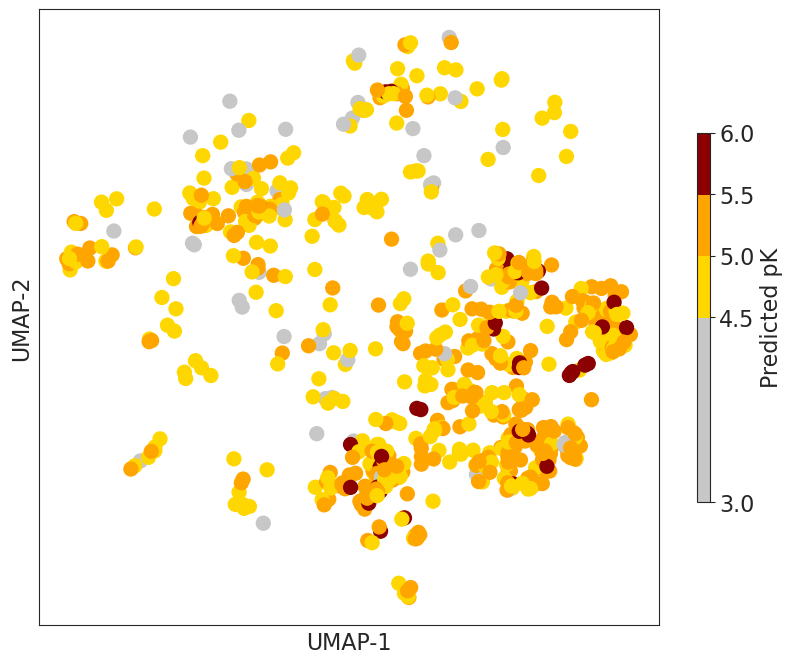

In [29]:
#sars-cov-2-main-protease-al-study-plip
cycle_dict = extract_cycles(concatenated_df)

def fid_filter(mask_df):
    mask = umap_df['fid'].isin(mask_df['fid'])
    filtered_df = umap_df[mask]
    return filtered_df

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

# Custom color map and normalization
my_colors = ['#c7c7c7', 'gold', 'orange', 'red', 'darkred']
my_cmap = ListedColormap(my_colors)
bounds = [3, 4.5, 5, 5.5, 6]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

def plot_umap(df, title, size=100):
    sns.set_style('white')
    plt.figure(figsize=(10, 8))

    # Use custom colormap and norm
    points = plt.scatter(x=df['UMAP-1'], y=df['UMAP-2'], c=df['cnnaffinity'], cmap=my_cmap, norm=my_norm, s=size)
    
    # Creating color bar and legend
    cbar = plt.colorbar(points, spacing='proportional', ticks=bounds, shrink=0.6, aspect=30)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Predicted pK', fontsize=16) 
    #plt.title(f'Chemical space UMAP - {title}', fontsize=16)
    plt.xlabel('UMAP-1', fontsize=16)
    plt.ylabel('UMAP-2', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    
    #plt.legend(title='CNNaffinity', title_fontsize=14, fontsize=14, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(title, bbox_inches='tight')
    plt.show()
    
cycles = ['1','13']
for i, df in enumerate(cycle_dict.values()):
    number_of_zeros = (df['cnnaffinity'] == 0).sum()
    mean_value = df['cnnaffinity'].mean()
    print(f'mean cnnaffinity: {mean_value}, # of 0s: {number_of_zeros}')
    filtered_df = fid_filter(df)
    print(filtered_df)
    #cycle = str(filtered_df['cycle'].iloc[0])
    #print(cycle)
    filtered_df['cnnaffinity'] = filtered_df['cnnaffinity'].astype(float)
    filtered_df = filtered_df[filtered_df['cnnaffinity'] > 0]
    plot_umap(filtered_df, f'{cycles[i]}',)

## Fig 6

Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 

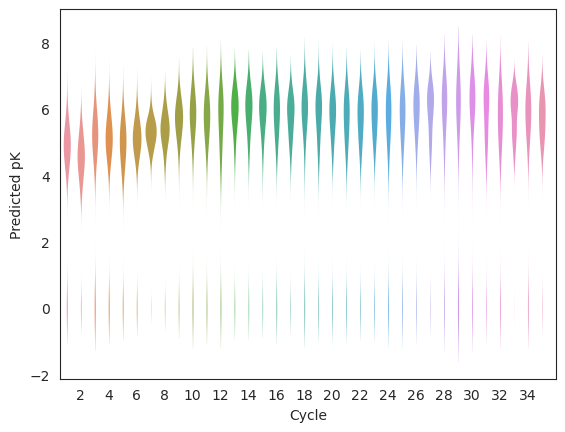

Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 

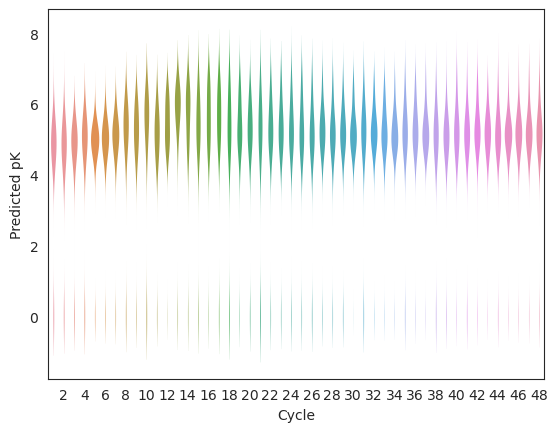

Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['combo1', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Inde

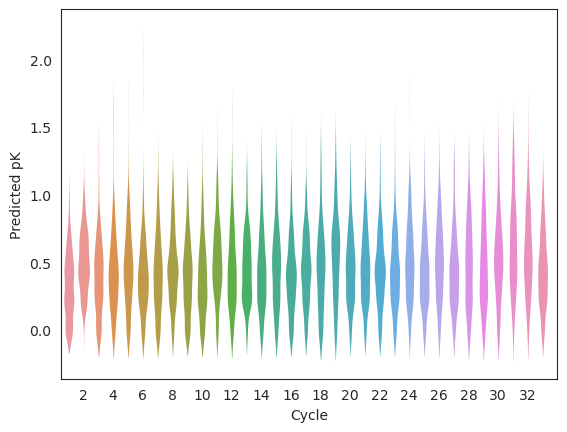

Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['plip', 'Smiles', 'h'

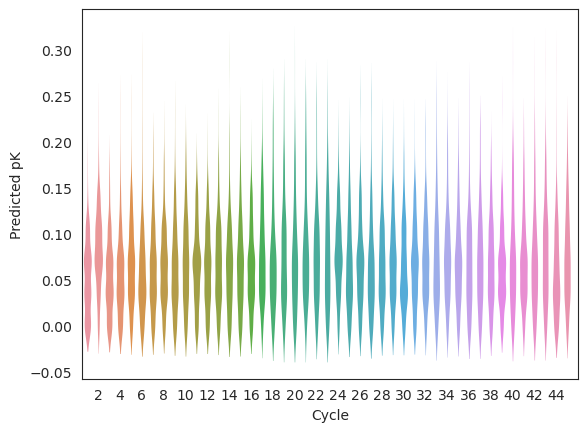

In [65]:
#FIG X
#all 4 rainbow violin plot(s) for enamine expts

def create_violin_plot(df_combined, title, hline=None):
    """
    Load data from a df and create a violin plot with optional horizontal line.
    
    Parameters:
    - df_combined: DataFrame containing the data.
    - hline: Optional; y-value for a horizontal line across the plot.
    
    Returns:
    None.
    """
    
    df_combined['cycle'] = df_combined['cycle'].astype('int')
    df_combined['cnnaffinity'] = df_combined['cnnaffinity'].astype('float')
    plot_title = df_combined['expt'].iloc[0]

    # create violin plot without black borders and with specified inner
    sns.violinplot(x='cycle', y='cnnaffinity', data=df_combined, linewidth=0, edgecolor='none')
    #ax.set_facecolor('white')
    # add optional horizontal line
    if hline is not None:
        plt.axhline(y=hline, color='black', linewidth=2)  # increase thickness of hline
    
    plt.xlabel('Cycle')
    plt.ylabel('Predicted pK')
    
    plt.xticks(range(min(df_combined['cycle']), max(df_combined['cycle']) + 1, 2))
    plt.savefig(f'{title}')
    plt.show()
    return df_combined
dirs = ['sars-cov-2-main-protease-al-study','sars-cov-2-main-protease-al-study-b10-r1-extended', 'sars-cov-2-main-protease-al-study-combo1', \
 'sars-cov-2-main-protease-al-study-plip']

for d in dirs:
    combined_df = create_test_df(f'/home/cree/code/gal/cs50k/enamine_study/{d}/generated')
    
    combined_df = combined_df.rename(columns={'Cycle': 'cycle'})
    create_violin_plot(combined_df, hline=None, title=f'/home/cree/code/al_data/{d}.png')

## AL regression vs CNNaffinity plot

In [ ]:
# al regression model vs cnnaffinity for a random rep & parameter
os.chdir('/home/cree/code/gal/cs50k/rep_3/gp_300_UCB_True_10/')

import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def create_test_df(directory):
    """
    Concatenate all selection.csv files from each cycle directory within the specified directory.

    Parameters:
    - directory: str, the path to the directory containing cycle folders.

    Returns:
    - all_selections_df: DataFrame, containing all the data with an additional 'cycle' column.
    """
    # Initialize an empty DataFrame
    all_selections_df = []
    # List all cycle directories in the specified directory
    cycle_dirs = [d for d in os.listdir(directory) if
                  os.path.isdir(os.path.join(directory, d)) and d.startswith('cycle_') and not d.endswith('0001')]
    cycle_dirs = sorted(cycle_dirs, key=lambda x: int(x.split('_')[1]))



    print(cycle_dirs)
    # Iterate over each directory and append the data to the DataFrame
    for cycle_dir in cycle_dirs:
        cycle_path = os.path.join(directory, cycle_dir, 'virtual_library_with_predictions.csv')
        #print(cycle_path)
        if os.path.exists(cycle_path):
            # Read the selection.csv file
            cycle_df = pd.read_csv(cycle_path)

            # Add a 'cycle' column to keep track of the source
            cycle_number = int(cycle_dir.split('_')[1])  # Extract cycle number from the directory name
            cycle_df['cycle'] = cycle_number
            cycle_df['regression'] = cycle_df['regression'].abs()
            # cycle_df['cnnaffinity'].astype('float').dtypes

            # Append the DataFrame to the main DataFrame
            all_selections_df.append(cycle_df)
            #all_selections_df['expt] = directory
    return all_selections_df

oracle_csv_path = '/home/cree/code/gal/cs50k/cs_49k.csv'
oracle_df = pd.read_csv(oracle_csv_path)

directory = '.'
cycle_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
cycle_dirs

a = create_test_df('.')
#len(a)

def calc_rmse(df_list):
    rmse_list = []
    print(f'calculating rmses for {len(df_list)} cycles')
    for i, df in enumerate(df_list):
        # Merge with oracle_df on 'Smiles'
        merged_df = pd.merge(df, oracle_df, how='outer', on='Smiles')
        # Calculate RMSE
        rmse = mean_squared_error(merged_df['cnnaffinity_y'], merged_df['regression'], squared=False)
        rmse_list.append(rmse)
        print(f'rmse for cycle {i} is {rmse}')
        print(f'df:\n {df}')
        #print(f'cycle number: {len(rmse_list)}')
    return rmse_list

#a[0].reset_index(
b = pd.merge(a[-1],oracle_df, how='outer', on='Smiles')
b

In [ ]:
merged_df_last = b

# Calculate RMSE
# Prepare the data
y = merged_df_last['regression']
x = merged_df_last['cnnaffinity_y']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.1)  # alpha for transparency in case of overlapping points

# Adding labels and title
plt.xlabel('CNNaffinity')
plt.ylabel('Regression Model Pred. CNNaffinity')
#plt.title('Scatter Plot of RMSE vs cnnaffinity_y')

# Display the plot
plt.show()

/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


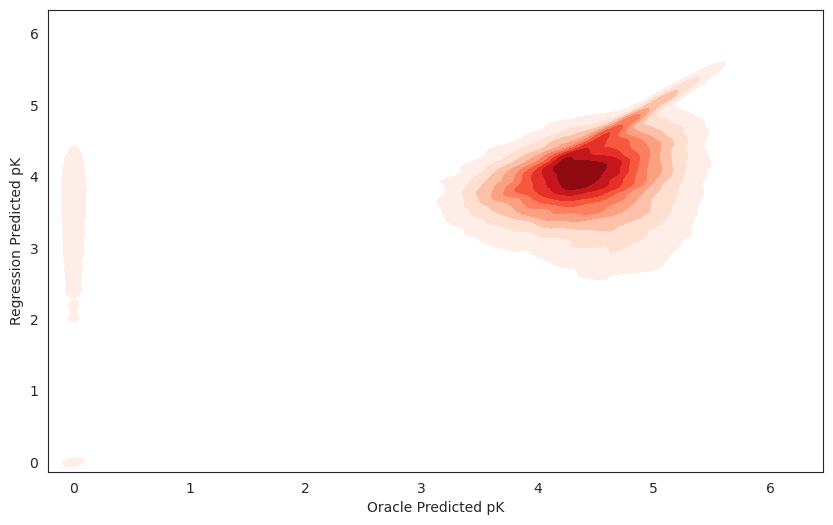

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data
x = merged_df_last['cnnaffinity_y']
y = merged_df_last['regression']

# Create a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x, y, cmap="Reds", shade=True, bw_adjust=0.5)

# Adding labels
plt.xlabel('Oracle Predicted pK')
plt.ylabel('Regression Predicted pK')

# Display the plot
plt.show()